### Основная цель: построить модель, которая будет предсказывать вероятность закрытия кредита раньше половины срока


Описание переменных :

account_rk - уникальный номер кредитного счета

utilization_dt - дата начала использования кредита

credit_type - тип кредита

duration - текущий срок жизни кредита

deb_coming - сумма поступлений на дебетовую карту

deb_transactions - сумма транзакций с дебетовой карты

insurance_payment - платежи по страховке

mob_days - кол-во дней, в которых использовалось мобильное приложение

tarif_type - тип тарифа

monthly_income_amt - доход

rp - размер регулярного платежа по кредиту

initial_term - изначальный срок по кредиту

sum_approved - одобренная сумма кредита

approv_vs_request - отношение одобренной суммы к запрошенной

loyalty_coeff - коэффициент лояльности клиента

segment - сегмент

closed_flg - флаг закрытия кредита

pd_model_new_norm- вероятность дефолта кредита

In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
import sklearn.metrics as metrics

In [2]:
dt = pd.read_csv('week 11.csv', sep=';', index_col=0)
dt.head()

,account_rk,utilization_dt,credit_type,duration,deb_coming,deb_transactions,insurance_payment,mob_days,tarif_type,monthly_income_amt,rp,initial_term,sum_approved,approv_vs_request,loyalty_coeff,segment,closed_flg,pd_model
47242,289097.0,2018-09-23,1,21.0,40814.0,-7191.0,0.0,10.0,one,103492.0,21716.0,36.0,530000.0,1.722223,0.0000,4.0,0.0,0.035133
122948,393796.0,2019-11-27,1,12.0,76528.0,12532.0,0.0,23.0,not_one,80094.0,11486.0,32.0,225000.0,-0.663957,0.0000,4.0,0.0,0.026019
201566,539112.0,2020-09-25,1,1.0,49854.0,28671.0,0.0,31.0,one,94485.0,17008.0,38.0,280000.0,-0.675823,0.2306,4.0,0.0,0.005385
27012,261769.0,2018-07-11,1,28.0,-6453.0,8454.0,0.0,3.0,not_one,63285.0,8925.0,38.0,230000.0,3.689388,0.0000,4.0,0.0,0.014340
94025,350912.0,2019-05-28,1,5.0,11070.0,-9936.0,0.0,19.0,one,66232.0,9990.0,39.0,155000.0,-0.276433,0.0000,4.0,0.0,0.059922


In [3]:
dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 209806 entries, 47242 to 86893
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   account_rk          209806 non-null  float64
 1   utilization_dt      209806 non-null  object 
 2   credit_type         209806 non-null  int64  
 3   duration            209806 non-null  float64
 4   deb_coming          209806 non-null  float64
 5   deb_transactions    209806 non-null  float64
 6   insurance_payment   209806 non-null  float64
 7   mob_days            209806 non-null  float64
 8   tarif_type          209806 non-null  object 
 9   monthly_income_amt  209645 non-null  float64
 10  rp                  209806 non-null  float64
 11  initial_term        209806 non-null  float64
 12  sum_approved        209806 non-null  float64
 13  approv_vs_request   209730 non-null  float64
 14  loyalty_coeff       209806 non-null  float64
 15  segment             200828 non-

In [4]:
dt.utilization_dt = pd.to_datetime(dt.utilization_dt)

### Первичная обработка данных

(194215, 18)

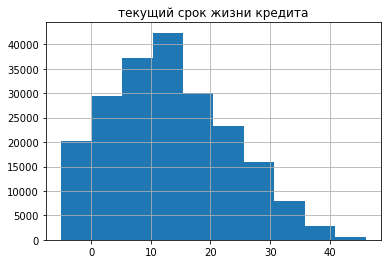

In [5]:
dt.duration.hist()
plt.title('текущий срок жизни кредита');
# есть отрицательные значения - некорректность 
dt = dt[dt.duration >= 0]
dt.shape

In [6]:
(dt.deb_coming < dt.deb_transactions).sum()
# в дебетовых картах сумма поступлений меньше суммы транзакций. Некорректные данные
dt = dt[dt.deb_coming >= dt.deb_transactions]
dt.shape

(159042, 18)

(150792, 18)

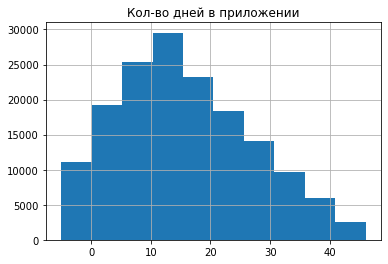

In [7]:
# dt.insurance_payment.value_counts()
dt.mob_days.hist()
plt.title('Кол-во дней в приложении')
# есть отрицательное количество дней - некорректные данные
dt = dt[dt.mob_days >= 0]
dt.shape

In [8]:
dt.tarif_type = dt.tarif_type.map({'one': 1, 'not_one': 0})
dt.tarif_type.value_counts()

1    111370
0     39422
Name: tarif_type, dtype: int64

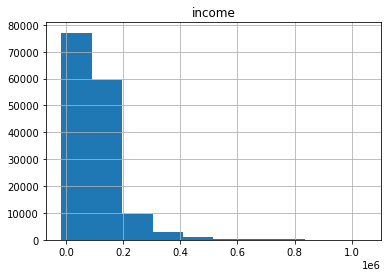

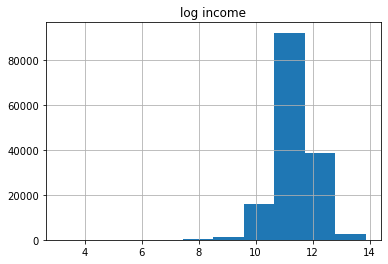

(150621, 19)

In [9]:
dt.monthly_income_amt.hist()
plt.title('income')
plt.show();
dt = dt[dt.monthly_income_amt >= 0]
dt['monthly_income_amt_log'] =  np.log(dt.monthly_income_amt)
dt.monthly_income_amt_log.hist()
plt.title('log income')
plt.show();
dt.shape

rp - размер регулярного платежа по кредиту

initial_term - изначальный срок по кредиту

sum_approved - одобренная сумма кредита

approv_vs_request - отношение одобренной суммы к запрошенной

In [10]:
dt = dt[dt['rp'] * dt['initial_term'] >= dt.sum_approved] 
# Сумма выплат должна быть не меньше размера кредита
dt.shape

(122313, 19)

In [11]:
# dt = dt[dt['approv_vs_request'] >= 0]
# dt.shape
# не будем использовать эту переменную, так как ее чистка убирает большую долю наблюдений

In [48]:
features = ['credit_type', 'duration', 'deb_coming',
       'deb_transactions', 'insurance_payment', 'mob_days', 'tarif_type',
       'rp', 'initial_term', 'sum_approved',
       'loyalty_coeff', 'segment', 
       'pd_model', 'monthly_income_amt_log']
len(features)

14

### Целевая переменная

Основная цель: построить модель, которая будет предсказывать вероятность закрытия кредита раньше половины срока. 
1, если кредит закрыт и duration меньше половины начального срока
0, иначе

In [12]:
dt['target'] = 0
dt.loc[(dt.duration < (dt.initial_term / 2)) & (dt['closed_flg'] == 1), 'target'] = 1

In [13]:
dt.target.value_counts()

0    108146
1     14167
Name: target, dtype: int64

In [14]:
dt.target.value_counts(normalize=True)

0    0.884174
1    0.115826
Name: target, dtype: float64

Классы несбалсированные, поэтому я попробую два варианта балансировки классов

1. Из превалирующего класса будет выбрано столько случайных наблюдений, чтобы уровнять доли классов.
2. Я исскуственно увеличу выборку малого класса, выбирая наблюдения с повторениями + уменьшу кол-во наблюдений превалирующего класса.

#### Вариант 1

In [50]:
idx_for_balance = dt[dt.target == 0].sample(frac=1/7).index.to_list() + dt[dt.target == 1].index.to_list()

In [51]:
dt_1 = dt.loc[idx_for_balance, :]

In [52]:
dt_1.dropna(subset=features).info()
# в сегменте и вероятности деволта нет данных, пока что попробуем их не использовать

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28718 entries, 37822 to 202251
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   account_rk              28718 non-null  float64       
 1   utilization_dt          28718 non-null  datetime64[ns]
 2   credit_type             28718 non-null  int64         
 3   duration                28718 non-null  float64       
 4   deb_coming              28718 non-null  float64       
 5   deb_transactions        28718 non-null  float64       
 6   insurance_payment       28718 non-null  float64       
 7   mob_days                28718 non-null  float64       
 8   tarif_type              28718 non-null  int64         
 9   monthly_income_amt      28718 non-null  float64       
 10  rp                      28718 non-null  float64       
 11  initial_term            28718 non-null  float64       
 12  sum_approved            28718 non-null  f

In [53]:
dt_1.dropna(subset=features).target.value_counts()

0    14655
1    14063
Name: target, dtype: int64

In [54]:
dt_1 = dt_1.dropna(subset=features)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(dt_1[features], dt_1['target'], test_size=0.3)

In [56]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [57]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_pred, y_test))

[[2516 1863]
 [1137 3100]]
              precision    recall  f1-score   support

           0       0.57      0.69      0.63      3653
           1       0.73      0.62      0.67      4963

    accuracy                           0.65      8616
   macro avg       0.65      0.66      0.65      8616
weighted avg       0.67      0.65      0.65      8616



In [58]:
y_pred = model.predict_proba(X_test)[:, 1]

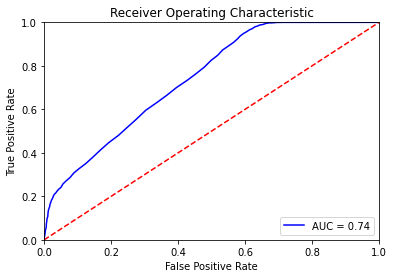

In [60]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


auc=0.722


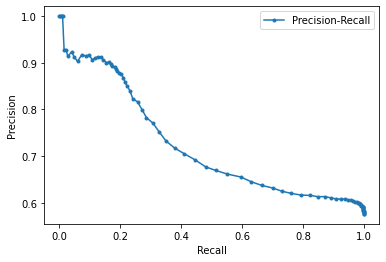

In [62]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred)
lr_auc = auc(lr_recall, lr_precision)
print('auc=%.3f' % (lr_auc))

# plot the precision-recall curves
plt.plot(lr_recall, lr_precision, marker='.', label='Precision-Recall')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [63]:
tree_params = {'max_features': range(5,14)              }
tree_grid = GridSearchCV(RandomForestClassifier(), tree_params,cv=5, n_jobs=-1)
tree_grid.fit(X_train, y_train)
tree_grid.best_params_

{'max_features': 11}

In [64]:
model = tree_grid.best_estimator_

In [65]:
y_pr_best = model.predict_proba(X_test)[:, 1]
y_predict = model.predict(X_test)

In [66]:
print(confusion_matrix(y_test,y_predict))
print(classification_report(y_predict, y_test))

[[2494 1885]
 [1046 3191]]
              precision    recall  f1-score   support

           0       0.57      0.70      0.63      3540
           1       0.75      0.63      0.69      5076

    accuracy                           0.66      8616
   macro avg       0.66      0.67      0.66      8616
weighted avg       0.68      0.66      0.66      8616



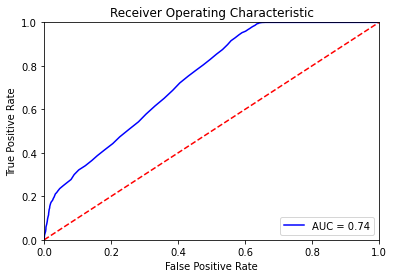

In [68]:
# TEST
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pr_best)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


auc=0.717


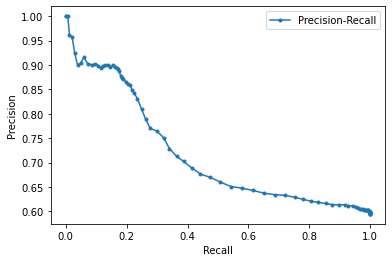

In [67]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pr_best)
lr_auc = auc(lr_recall, lr_precision)
print('auc=%.3f' % (lr_auc))

# plot the precision-recall curves
plt.plot(lr_recall, lr_precision, marker='.', label='Precision-Recall')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [72]:
#Важность переменных
pd.Series(model.feature_importances_, index = features).sort_values(ascending=False)

duration                  0.188192
initial_term              0.102640
pd_model                  0.086374
deb_coming                0.086022
deb_transactions          0.084616
monthly_income_amt_log    0.084417
rp                        0.083433
sum_approved              0.074163
insurance_payment         0.068092
mob_days                  0.062270
loyalty_coeff             0.046669
segment                   0.017314
tarif_type                0.008168
credit_type               0.007630
dtype: float64

#### Вариант 2

In [76]:
one_for_balance = dt[dt.target == 1].sample(frac=1/2).index.to_list() + dt[dt.target == 1].index.to_list()+ dt[dt.target == 0].sample(frac=1/4).index.to_list()
dt_2 = dt.loc[one_for_balance, :]
dt_2.target.value_counts()

0    27036
1    21251
Name: target, dtype: int64

In [77]:
dt_2 = dt_2.dropna(subset=features)

In [78]:
X_train, X_test, y_train, y_test = train_test_split(dt_2[features], dt_2['target'], test_size=0.3)

In [79]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [80]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_pred, y_test))

[[6183 1597]
 [1768 4483]]
              precision    recall  f1-score   support

           0       0.79      0.78      0.79      7951
           1       0.72      0.74      0.73      6080

    accuracy                           0.76     14031
   macro avg       0.76      0.76      0.76     14031
weighted avg       0.76      0.76      0.76     14031



In [81]:
y_pred = model.predict_proba(X_test)[:, 1]

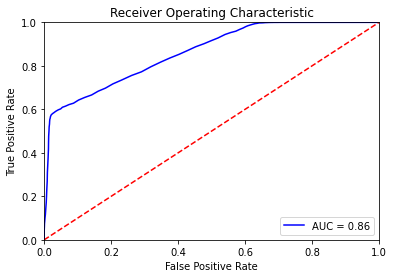

In [83]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


auc=0.854


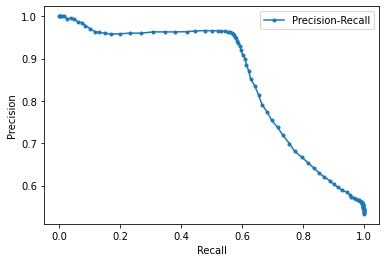

In [84]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc


lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pred)
lr_auc = auc(lr_recall, lr_precision)
print('auc=%.3f' % (lr_auc))

# plot the precision-recall curves
plt.plot(lr_recall, lr_precision, marker='.', label='Precision-Recall')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [85]:
tree_params = {'max_features': range(5,10)}
tree_grid = GridSearchCV(RandomForestClassifier(), tree_params,cv=5, n_jobs=-1)
tree_grid.fit(X_train, y_train)
tree_grid.best_params_

{'max_features': 5}

In [86]:
model = tree_grid.best_estimator_

In [87]:
y_pr_best = model.predict_proba(X_test)[:, 1]
y_predict = model.predict(X_test)

In [88]:
print(confusion_matrix(y_test,y_predict))
print(classification_report(y_predict, y_test))

[[6112 1668]
 [1746 4505]]
              precision    recall  f1-score   support

           0       0.79      0.78      0.78      7858
           1       0.72      0.73      0.73      6173

    accuracy                           0.76     14031
   macro avg       0.75      0.75      0.75     14031
weighted avg       0.76      0.76      0.76     14031



auc=0.851


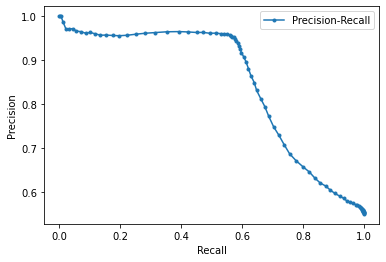

In [89]:
lr_precision, lr_recall, _ = precision_recall_curve(y_test, y_pr_best)
lr_auc = auc(lr_recall, lr_precision)
print('auc=%.3f' % (lr_auc))

# plot the precision-recall curves
plt.plot(lr_recall, lr_precision, marker='.', label='Precision-Recall')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

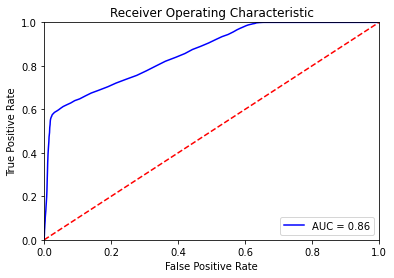

In [90]:
fpr, tpr, threshold = metrics.roc_curve(y_test, y_pr_best)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [91]:
pd.Series(model.feature_importances_, index = features).sort_values(ascending=False)
# for k, val in enumerate(model.feature_importances_):
#     print('feature {0} : impotance {1}'.format(features[k], round(val,3)))

duration                  0.173120
initial_term              0.094204
deb_coming                0.089334
pd_model                  0.087201
monthly_income_amt_log    0.087104
deb_transactions          0.086734
rp                        0.085293
sum_approved              0.076832
insurance_payment         0.068253
mob_days                  0.064339
loyalty_coeff             0.049275
segment                   0.018610
credit_type               0.010037
tarif_type                0.009664
dtype: float64

### Стабильность оценок

Проверяется периодически за какой-то промежуток времени, определяется точность предсказаний, и если она значительно меньше, то необходимо рассмотреть данные и понять, что изменилось. Может быть в модель необходимо добавить сезонность. 